# Experiments in the Section 4.2 (Robustness)

### Csv files are already here. You can run the entiere notebook. If you want to run the entire experiment again, you have to run the three following script: experience_robu_10_repetition.py, experience_robu_10_repetition_3.py  and xp_robu_repetition10_5.py, it takes some hours each. They will automatically write the csv files in the same folder and then you can rerun this notebook to check the results.


### Importing libraries:

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
from functools import partial
from itertools import combinations
import csv
import warnings
warnings.filterwarnings("ignore")
import FCHD
import os

### Normal datasets:

In [2]:
X = pd.read_csv('Dataset_brownian_geom.csv', header=None)
X = X.as_matrix()
X = X[:100]
Y = pd.read_csv('Dataset_deux.csv', header=None)
Y = Y.as_matrix()
Y = Y[:100]

### Ranking metrics:

In [3]:
def kendall_tau(x,y):
    n = x.shape[0]
    S = 0
    z=0
    for i in range(n):
        for j in range(i+1,n):
            S += 1 * ( ((x[i] - x[j]) * (y[i] - y[j])) < 0 )
            
    return S / (n * (n - 1) / 2  )

## Functional Stahel-Donoho-Outlyingness, Functional Tukey depth and Functional Isolation Forest algorithm

In [4]:
def functional_Stahel_Donoho(X_train, X_test):
    m = X_train.shape[1]
    n1 = X_train.shape[0]
    n2 = X_test.shape[0]
    S = np.zeros((n2,m))
    for t in range(m):
        for i in range(n2):
            S[i,t] = np.abs(X_test[i,t] - np.median(X_train[:,t]))
        if (np.median(np.abs(X_train[:,t]-np.median(X_train[:,t]))) > 0):
            S[:,t] = 1 / (1 + S[:,t] / np.median(np.abs(X_train[:,t]-np.median(X_train[:,t]))))
    
    return  np.mean(S, axis=1) 

In [5]:
def functional_Tukey(X_train, X_test):
    m = X_train.shape[1]
    n1 = X_train.shape[0]
    n2 = X_test.shape[0]
    S = np.zeros((n2,m))
    Z = np.zeros(n1)
    for t in range(m):
        for i in range(n2):
            Z = X_train[:,t] - X_test[i, t]
            S[i, t] = np.sum(1* (Z >0))
        S[:, t] = S[:, t]  / n1
        S[:, t]  = np.minimum(S[:, t] , 1 - S[:, t]  )
    return np.mean(S, axis=1)

In [6]:
import FIF # Functional isolation Forest algorithm

# Construction of anomalies:

In [7]:
times = np.linspace(0,1,X.shape[1])
outliers_proportion = [0.05, 0.1, 0.15,  0.25]
anomalies_number = np.int(outliers_proportion[3] * X.shape[0])

# Location anomalies:

### Dataset (a):

In [8]:
np.random.seed(42)
Z = np.zeros((anomalies_number, X.shape[1]))
for i in range(anomalies_number):
    k = np.random.choice(np.array([60]))
    Z[i] = X[k] + X[k]* np.random.uniform(0,1)

X1 = np.concatenate((X,Z[:5]))
X2 = np.concatenate((X,Z[:10]))
X3 = np.concatenate((X,Z[:15]))
X4 = np.concatenate((X,Z[:25]))

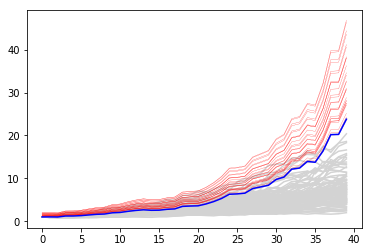

In [9]:
for i in range(X.shape[0]):
    plt.plot(X[i],c='lightgray')
for i in range(Z.shape[0]):
    plt.plot(Z[i],c='r', linewidth=0.2)
plt.plot(X[60],c='b')

# Shape anomalies:

### Dataset (b):

In [10]:
np.random.seed(42)
W1 = np.zeros((anomalies_number, Y.shape[1]))
for i in range(anomalies_number):
    k = np.random.choice(np.array([1]))
    f = np.random.uniform(1,10)
    W1[i] = Y[k] +  0.01 * np.cos(times *
         2 * np.pi*f) + 0.01 * np.sin(times * 2 * np.pi*f)

shape_Y1 = np.concatenate((Y,W1[:5]))
shape_Y2 = np.concatenate((Y,W1[:10]))
shape_Y3 = np.concatenate((Y,W1[:15]))
shape_Y4 = np.concatenate((Y,W1[:25]))

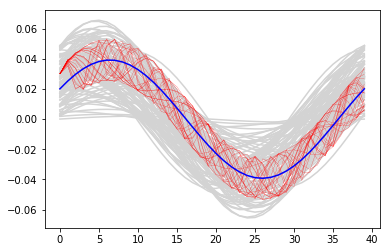

In [11]:
for i in range(Y.shape[0]):
    plt.plot(Y[i],c='lightgray')
for i in range(W1.shape[0]):
    plt.plot(W1[i],c='r', linewidth=0.2)
plt.plot(Y[1],c='b')

# Isolated anomalies:

### Dataset (b):

In [12]:
np.random.seed(42)
W2 = np.zeros((anomalies_number, Y.shape[1]))
for i in range(anomalies_number):
    k = np.random.choice(np.arange(Y.shape[0]))
    f = np.random.uniform(1,10)
    W2[i] = Y[k]
    l = np.random.choice(np.arange(X.shape[1]))
    K = np.random.uniform(0.03,0.06)
    W2[i,l] += K 

isol_Y1 = np.concatenate((Y,W2[:5]))
isol_Y2 = np.concatenate((Y,W2[:10]))
isol_Y3 = np.concatenate((Y,W2[:15]))
isol_Y4 = np.concatenate((Y,W2[:20]))
isol_Y5 = np.concatenate((Y,W2[:30]))

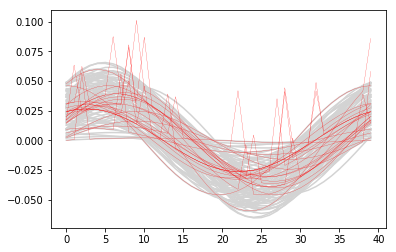

In [13]:
for i in range(Y.shape[0]):
    plt.plot(Y[i],c='lightgray')
for i in range(W2.shape[0]):
    plt.plot(W2[i],c='r', linewidth=0.2)

# Ten repetitions:

### Location anomalies with dataset (a)

In [14]:
S = pd.read_csv('xp_robu_repetition10.csv', header=None)
S = S.as_matrix()
S = S.reshape(2400)

In [15]:
S1 = np.zeros((100, 6, 4))
k = 0
for i in range(4):
    for j in range(6):
        S1[:,j, i] = S[(k * 100):((k+1) * 100)]
        k +=1

In [16]:
KT_FCHD = np.zeros(6)
KT_FSDO = np.zeros(6)
KT_FT = np.zeros(6)
KT_FIF = np.zeros(6)
for i in range(6):
    G1 = np.zeros(len(S1[:, 0, 0]))
    V1 = np.zeros(len(S1[:, 0, 0]))
    G1[np.argsort(1-S1[:, 0, 0])] = np.arange(len(S1[:, i, 0]))
    V1[np.argsort(1-S1[:, i, 0])] = np.arange(len(S1[:, i, 0]))
    KT_FCHD[i] = kendall_tau(G1, V1)
    
    G2 = np.zeros(len(S1[:, 0, 1]))
    V2 = np.zeros(len(S1[:, 0, 1]))
    G2[np.argsort(1-S1[:, 0, 1])] = np.arange(len(S1[:, i, 1]))
    V2[np.argsort(1-S1[:, i, 1])] = np.arange(len(S1[:, i, 1]))
    
    KT_FSDO[i] = kendall_tau(G2,V2)
    
    G3 = np.zeros(len(S1[:, 0, 2]))
    V3 = np.zeros(len(S1[:, 0, 2]))
    G3[np.argsort(1-S1[:, 0, 2])] = np.arange(len(S1[:, i, 2]))
    V3[np.argsort(1-S1[:, i, 2])] = np.arange(len(S1[:, i, 2]))    
    
    KT_FT[i] = kendall_tau(G3,V3)
    
    G4 = np.zeros(len(S1[:, 0, 3]))
    V4 = np.zeros(len(S1[:, 0, 3]))
    G4[np.argsort(1-S1[:, 0, 3])] = np.arange(len(S1[:, i, 3]))
    V4[np.argsort(1-S1[:, i, 3])] = np.arange(len(S1[:, i, 3]))        
    
    KT_FIF[i] = kendall_tau(G4,V4)

In [17]:
KT_FCHD

array([0.        , 0.00646465, 0.01333333, 0.02161616, 0.04323232,
       0.05252525])

In [18]:
KT_FSDO

array([0.        , 0.0359596 , 0.07252525, 0.10121212, 0.16727273,
       0.19838384])

In [19]:
KT_FT

array([0.        , 0.05111111, 0.09535354, 0.12707071, 0.19656566,
       0.22929293])

In [20]:
KT_FIF

array([0.        , 0.06989899, 0.08181818, 0.07313131, 0.07252525,
       0.08929293])

### Isolated anomalies with dataset (b)

In [21]:
S = pd.read_csv('xp_robu_repetition10_5.csv', header=None)
S = S.as_matrix()
S = S.reshape(2400)
S1 = np.zeros((100, 6, 4))
k = 0
for i in range(4):
    for j in range(6):
        S1[:,j, i] = S[(k * 100):((k+1) * 100)]
        k +=1

In [22]:
KT_FCHD5 = np.zeros(6)
KT_FSDO5 = np.zeros(6)
KT_FT5 = np.zeros(6)
KT_FIF5 = np.zeros(6)

for i in range(6):
    G1 = np.zeros(len(S1[:, 0, 0]))
    V1 = np.zeros(len(S1[:, 0, 0]))
    G1[np.argsort(1-S1[:, 0, 0])] = np.arange(len(S1[:, i, 0]))
    V1[np.argsort(1-S1[:, i, 0])] = np.arange(len(S1[:, i, 0]))
    KT_FCHD5[i] = kendall_tau(G1, V1)
    
    G2 = np.zeros(len(S1[:, 0, 1]))
    V2 = np.zeros(len(S1[:, 0, 1]))
    G2[np.argsort(1-S1[:, 0, 1])] = np.arange(len(S1[:, i, 1]))
    V2[np.argsort(1-S1[:, i, 1])] = np.arange(len(S1[:, i, 1]))
    
    KT_FSDO5[i] = kendall_tau(G2,V2)
    
    G3 = np.zeros(len(S1[:, 0, 2]))
    V3 = np.zeros(len(S1[:, 0, 2]))
    G3[np.argsort(1-S1[:, 0, 2])] = np.arange(len(S1[:, i, 2]))
    V3[np.argsort(1-S1[:, i, 2])] = np.arange(len(S1[:, i, 2]))    
    
    KT_FT5[i] = kendall_tau(G3,V3)
    
    G4 = np.zeros(len(S1[:, 0, 3]))
    V4 = np.zeros(len(S1[:, 0, 3]))
    G4[np.argsort(1-S1[:, 0, 3])] = np.arange(len(S1[:, i, 3]))
    V4[np.argsort(1-S1[:, i, 3])] = np.arange(len(S1[:, i, 3]))        
    
    KT_FIF5[i] = kendall_tau(G4,V4)

In [23]:
KT_FCHD5

array([0.        , 0.0030303 , 0.01252525, 0.00949495, 0.01616162,
       0.02424242])

In [24]:
KT_FSDO5

array([0.        , 0.00787879, 0.03575758, 0.03151515, 0.07191919,
       0.09373737])

In [25]:
KT_FT5

array([0.        , 0.00727273, 0.02686869, 0.02666667, 0.0589899 ,
       0.07191919])

In [26]:
KT_FIF5

array([0.        , 0.09333333, 0.12040404, 0.11090909, 0.10484848,
       0.11858586])

### Shape anoamlies with dataset (b)

In [27]:
S = pd.read_csv('xp_robu_repetition10_3.csv', header=None)
S = S.as_matrix()
S = S.reshape(2400)
S1 = np.zeros((100, 6, 4))
k = 0
for i in range(4):
    for j in range(6):
        S1[:,j, i] = S[(k * 100):((k+1) * 100)]
        k +=1

In [28]:
KT_FCHD3 = np.zeros(6)
KT_FSDO3 = np.zeros(6)
KT_FT3 = np.zeros(6)
KT_FIF3 = np.zeros(6)
for i in range(6):
    G1 = np.zeros(len(S1[:, 0, 0]))
    V1 = np.zeros(len(S1[:, 0, 0]))
    G1[np.argsort(1-S1[:, 0, 0])] = np.arange(len(S1[:, i, 0]))
    V1[np.argsort(1-S1[:, i, 0])] = np.arange(len(S1[:, i, 0]))
    KT_FCHD3[i] = kendall_tau(G1, V1)
    
    G2 = np.zeros(len(S1[:, 0, 1]))
    V2 = np.zeros(len(S1[:, 0, 1]))
    G2[np.argsort(1-S1[:, 0, 1])] = np.arange(len(S1[:, i, 1]))
    V2[np.argsort(1-S1[:, i, 1])] = np.arange(len(S1[:, i, 1]))
    
    KT_FSDO3[i] = kendall_tau(G2,V2)
    
    G3 = np.zeros(len(S1[:, 0, 2]))
    V3 = np.zeros(len(S1[:, 0, 2]))
    G3[np.argsort(1-S1[:, 0, 2])] = np.arange(len(S1[:, i, 2]))
    V3[np.argsort(1-S1[:, i, 2])] = np.arange(len(S1[:, i, 2]))    
    
    KT_FT3[i] = kendall_tau(G3,V3)
    
    G4 = np.zeros(len(S1[:, 0, 3]))
    V4 = np.zeros(len(S1[:, 0, 3]))
    G4[np.argsort(1-S1[:, 0, 3])] = np.arange(len(S1[:, i, 3]))
    V4[np.argsort(1-S1[:, i, 3])] = np.arange(len(S1[:, i, 3]))        
    
    KT_FIF3[i] = kendall_tau(G4,V4)

In [29]:
KT_FCHD3 

array([0.        , 0.00909091, 0.01959596, 0.02606061, 0.04181818,
       0.04707071])

In [30]:
KT_FSDO3

array([0.        , 0.01555556, 0.02929293, 0.04222222, 0.06646465,
       0.07353535])

In [31]:
KT_FT3

array([0.        , 0.01676768, 0.02929293, 0.04323232, 0.06646465,
       0.07676768])

In [32]:
KT_FIF3

array([0.        , 0.07393939, 0.07878788, 0.10181818, 0.13919192,
       0.1410101 ])